# Named Entity Recognition Modeling with Bidirectional LSTM

## Import Packages

In [1]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import pickle

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

## 개체명 인식 데이터 로드

In [2]:
ner_df = pd.read_pickle('./data/ner_df.pickle')
ner_df

,question,intent,tokenized_sample,ner_label
0,AJ네트웍스의 유사 종목,유사기업,"[AJ네트웍스, 의, 유사, 종목]","[B-STK, O, O, O]"
1,AJ네트웍스의 유사 종목 보여줘,유사기업,"[AJ네트웍스, 의, 유사, 종목, 보여줘]","[B-STK, O, O, O, O]"
2,AJ네트웍스의 유사 종목 알려줘,유사기업,"[AJ네트웍스, 의, 유사, 종목, 알려줘]","[B-STK, O, O, O, O]"
3,AJ네트웍스의 유사 종목 열람,유사기업,"[AJ네트웍스, 의, 유사, 종목, 열람]","[B-STK, O, O, O, O]"
4,AJ네트웍스와 유사 종목은 뭐가 있어?,유사기업,"[AJ네트웍스, 와, 유사, 종목, 은, 뭐, 가, 있, 어, ?]","[B-STK, O, O, O, O, O, O, O, O, O]"
...,...,...,...,...
131700,힘스 가격 추이 띄워,가격,"[힘스, 가격, 추이, 띄워]","[B-STK, B-PRI, I-PRI, O]"
131701,힘스 가격 추이 어때?,가격,"[힘스, 가격, 추이, 어때, ?]","[B-STK, B-PRI, I-PRI, O, O]"
131702,힘스 가격 추이 어떻게 돼?,가격,"[힘스, 가격, 추이, 어떻게, 돼, ?]","[B-STK, B-PRI, I-PRI, O, O, O]"
131703,힘스 가격 추이 궁금해,가격,"[힘스, 가격, 추이, 궁금, 해]","[B-STK, B-PRI, I-PRI, O, O]"


### ner_df 데이터 구조 시각화

In [3]:
ner_sentences = ner_df['tokenized_sample'].to_list()
ner_tags = ner_df['ner_label'].to_list()

샘플의 최대 길이 : 13
샘플의 평균 길이 : 5.092797


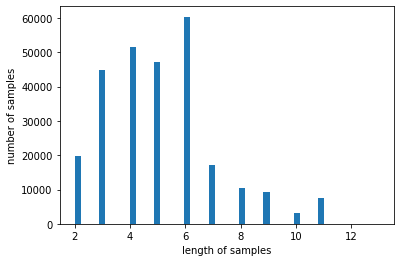

In [4]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in ner_sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, ner_sentences))/len(ner_sentences)))
plt.hist([len(s) for s in ner_sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 개체명 인식 데이터 Tokenizing

In [5]:
# 모든 단어를 사용하지만, Index 1에는 'Out of Vocabulary' 할당
src_tokenizer = Tokenizer(oov_token = 'OOV')
src_tokenizer.fit_on_texts(ner_sentences)
# Tagging 정보들은 내부적으로 대문자를 유지한채로 저장
tar_tokenizer = Tokenizer(lower = False)
tar_tokenizer.fit_on_texts(ner_tags)

In [6]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기: {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기: {}'.format(tag_size))

단어 집합의 크기: 3225
개체명 태깅 정보 집합의 크기: 8


In [7]:
print('단어 OOV의 인덱스: {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스: 1


In [8]:
X_data = src_tokenizer.texts_to_sequences(ner_sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [9]:
print(X_data[0], y_data[0])

[87, 35, 28, 26] [2, 1, 1, 1]


In [10]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'
index_to_ner

{1: 'O',
 2: 'B-STK',
 3: 'B-PRI',
 4: 'I-PRI',
 5: 'B-KEY',
 6: 'I-KEY',
 7: 'I-STK',
 0: 'PAD'}

In [11]:
decoded = []
for index in X_data[0]:
    decoded.append(index_to_word[index])
    
print('기존의 문장: {}'.format(ner_sentences[0]))
print('디코딩 문장: {}'.format(decoded))

기존의 문장: ['AJ네트웍스', '의', '유사', '종목']
디코딩 문장: ['aj네트웍스', '의', '유사', '종목']


In [12]:
max_len = 12
X_data = pad_sequences(X_data, padding = 'post', maxlen = max_len)
y_data = pad_sequences(y_data, padding = 'post', maxlen = max_len)

### train, test set으로 데이터 분리

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = .2, random_state = 42)

In [14]:
y_train = to_categorical(y_train, num_classes = tag_size)
y_test = to_categorical(y_test, num_classes = tag_size)

In [15]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (217274, 12)
훈련 샘플 레이블의 크기 : (217274, 12, 8)
테스트 샘플 문장의 크기 : (54319, 12)
테스트 샘플 레이블의 크기 : (54319, 12, 8)


## Tokenizer 저장

In [16]:
# %mkdir ./tokenizer
# %ls

In [17]:
with open('./tokenizer/ner_src_tokenizer.pickle', 'wb') as handle:
    pickle.dump(src_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
with open('./tokenizer/ner_tar_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tar_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Modeling

In [19]:
# # M1 mac GPU setting
# import tensorflow as tf
# tf.config.list_physical_devices('GPU')

In [20]:
# gpus = tf.config.experimental.list_physical_devices('GPU')

# if gpus:
#     # 텐서플로가 첫 번째 GPU만 사용하도록 제한
#     try:
#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#     except RuntimeError as e:
#     # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
#         print(e)

In [16]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [25]:
# %mkdir ./model
# %ls

LICENSE
data/
model/
named_entity_recognition_modeling.ipynb
scrapping/
tokenizer/
training_data_generate.ipynb


In [17]:
embedding_dim = 128
hidden_units = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero = True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences = True)))
model.add(TimeDistributed(Dense(tag_size, activation = ('softmax'))))
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.001), metrics = ['accuracy'])

reLR = ReduceLROnPlateau(patience = 5, verbose = 1, factor = .2)
es = EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = 3)
mc = ModelCheckpoint(filepath = './model/ner_bidirectional.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True, restore_best_weights = True)

history = model.fit(X_train, y_train, batch_size = 128, epochs = 10, validation_split = 0.2, shuffle = True, verbose = 1, callbacks = [es, mc, reLR])

Metal device set to: Apple M1


2022-05-31 16:01:57.216658: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-31 16:01:57.217076: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-31 16:01:58.313688: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2022-05-31 16:01:59.817462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-31 16:02:00.590511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-31 16:02:00.723867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-31 16:02:03.558476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-31 16:02:03.671043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1358/1358 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9869

2022-05-31 16:06:03.263097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-31 16:06:03.580835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-31 16:06:03.629884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_accuracy improved from -inf to 0.99990, saving model to ./model/ner_bidirectional.h5
1358/1358 [==============================] - 273s 196ms/step - loss: 0.0214 - accuracy: 0.9869 - val_loss: 1.8878e-04 - val_accuracy: 0.9999 - lr: 0.0010
Epoch 2/10
1358/1358 [==============================] - ETA: 0s - loss: 1.2519e-04 - accuracy: 0.9999
Epoch 00002: val_accuracy improved from 0.99990 to 0.99996, saving model to ./model/ner_bidirectional.h5
1358/1358 [==============================] - 269s 198ms/step - loss: 1.2519e-04 - accuracy: 0.9999 - val_loss: 8.3418e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/10
1358/1358 [==============================] - ETA: 0s - loss: 4.3159e-05 - accuracy: 1.0000
Epoch 00003: val_accuracy improved from 0.99996 to 0.99998, saving model to ./model/ner_bidirectional.h5
1358/1358 [==============================] - 272s 200ms/step - loss: 4.3159e-05 - accuracy: 1.0000 - val_loss: 4.4062e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/10
13

In [18]:
print('평가 결과: ', model.evaluate(X_train, y_train)[1])

6790/6790 [==============================] - 186s 27ms/step - loss: 5.8813e-06 - accuracy: 1.0000
평가 결과:  0.9999972581863403


### epoch 증가에 따른 accuracy, loss 변화 시각화

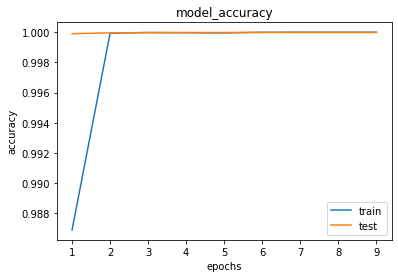

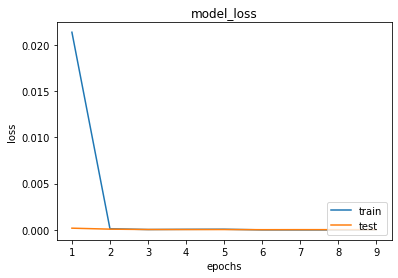

In [19]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'])
plt.plot(epochs, history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc = 'lower right')
plt.show()

epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc = 'lower right')
plt.show()

In [20]:
# sequence 를 NER tag 로 변환하는 함수
# 예측값을 index_to_ner 을 사용해서 tag 정보로 변경
def sequences_to_tag(sequences):
        result = []
        
        for sequence in sequences:
            temp = []
            for pred in sequence:
                pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0, 0]이면 1의 index 2를 반환
                temp.append(index_to_ner[pred_index].replace('PAD', 'O')) # PAD는 O로 변경
            result.append(temp)
        return result

## 개체명 인식 모델의 예측 성능 평가

### 예측값 산출 / 실제값과 예측값을 NER tag로 변경

In [24]:
y_predicted = model.predict(X_test)
pred_tags = sequences_to_tag(y_predicted) # predicted NER
test_tags = sequences_to_tag(y_test) # actual NER

2022-05-31 16:47:56.387870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-31 16:47:56.653868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-31 16:47:56.721622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [22]:
# pip install seqeval#

  Using cached seqeval-1.2.2-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


### F1 score 계산

In [23]:
from seqeval.metrics import f1_score, classification_report

In [25]:
print(classification_report(test_tags, pred_tags))
print('F1-score: {:.1%}'.format(f1_score(test_tags, pred_tags)))

              precision    recall  f1-score   support

         KEY       1.00      1.00      1.00      4106
         PRI       1.00      1.00      1.00     25467
         STK       1.00      1.00      1.00     50209

   micro avg       1.00      1.00      1.00     79782
   macro avg       1.00      1.00      1.00     79782
weighted avg       1.00      1.00      1.00     79782

F1-score: 100.0%
